# DEPLOY

# 0.0. Imports

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import s3fs
import inflection
import sklearn
import umap.umap_ as umap
from datetime import datetime as dtime
from matplotlib import pyplot as plt

from IPython.core.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx
from sklearn import ensemble      as en
from sklearn.manifold import TSNE
from plotly import express as px

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

pd.options.display.float_format = '{:.2f}'.format

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv',encoding='unicode_escape')

# drop extra columns
df_raw.drop('Unnamed: 8', axis=1, inplace=True)

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [5]:
# storing columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

## 1.2. Data dimensions

In [6]:
df1.shape

(541909, 8)

## 1.3. Data types

In [7]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

### 1.5.1 Description

In [9]:
# replace with existing description by stock_code
df1aux = df1[~df1['description'].isna()]
aux3 = df1aux[['stock_code', 'description']].drop_duplicates('stock_code')
df1 = df1.drop(columns='description')
df1_ = pd.merge(df1, aux3, how='left', on='stock_code')
df1_.isna().sum()

invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
description        112
dtype: int64

In [10]:
# the remaing 112 records have 0 values for unit_price. it is going to bel erased
df1_ = df1_.dropna(subset=['description'])

df1 = df1_.copy()

df1_.isna().sum()

invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
customer_id     134968
country              0
description          0
dtype: int64

### 1.5.2 Customer ID 

In [11]:
aux_na = df1[df1['customer_id'].isna()].copy()
aux_na['gross_revenue_na'] = aux_na['unit_price']*aux_na['quantity']
print("Total Gross Revenue NA $ %.2f" % aux_na['gross_revenue_na'].sum())
aux = df1[~df1['customer_id'].isna()].copy()
aux['gross_revenue_na'] = aux['unit_price']*aux['quantity']
print("Total Gross Revenue $ %.2f" % aux['gross_revenue_na'].sum())
print("Percentage of Total (not NA): %.2f" % (aux_na['gross_revenue_na'].sum()/aux['gross_revenue_na'].sum()*100), '%')

Total Gross Revenue NA $ 1447682.12
Total Gross Revenue $ 8300065.81
Percentage of Total (not NA): 17.44 %


In [12]:
df1_ = df1.copy()
df1_.shape

(541797, 8)

In [13]:
# create reference - artificial customer to not drop the records
df_backup = pd.DataFrame( aux_na['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 30000, 30000+len( df_backup ), 1) 

# merge original with reference dataframe
df1_ = pd.merge( df1_, df_backup, on='invoice_no', how='left' )

# coalesce (command from SQL)
df1_['customer_id'] = df1_['customer_id_x'].combine_first( df1_['customer_id_y'] )

# drop extra columns
df1_ = df1_.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [14]:
df1 = df1_.copy()
df1_.isna().sum()

invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
country         0
description     0
customer_id     0
dtype: int64

## 1.6. Change dtypes

In [15]:
# customer_id
df1['customer_id'] = df1['customer_id'].astype('int32')
df1['quantity'] = df1['quantity'].astype('int32')
df1.dtypes

invoice_no              object
stock_code              object
quantity                 int32
invoice_date    datetime64[ns]
unit_price             float64
country                 object
description             object
customer_id              int32
dtype: object

# <font color='red'> 2.0. Feature Engineering </font>

In [16]:
df2 = df1.copy()
df2.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'description', 'customer_id'],
      dtype='object')

### 2.1. GROSS REVENUE

In [17]:
# gross revenue
df2['gross_revenue'] = df2['unit_price'] * df2['quantity']

### 2.2. GOOD RETURN

In [18]:
df2['good_return'] = df2.apply(lambda x: 1 if (x['quantity'] < 0) & (x['unit_price'] > 0) else 0, axis=1)

### 2.3. QNTD ADJUSTMENT

In [19]:
df2['qtd_adjustment'] = df2.apply(lambda x: 1 if (x['quantity'] < 0) & (x['unit_price'] == 0) else 0, axis=1)

### 2.4. FREE PURCHASE

In [20]:
df2['free_purchase'] = df2.apply(lambda x: 1 if (x['quantity'] > 0) & (x['unit_price'] == 0) else 0, axis=1)

### 2.5. NORMAL PURCHASE

In [21]:
df2['normal_purchase'] = df2.apply(lambda x: 1 if (x['quantity'] > 0) & (x['unit_price'] > 0) else 0, axis=1)

# <font color='red'> 3.0. Filtragem de Variaveis </font>

In [22]:
df3 = df2.copy()
df3.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'description', 'customer_id', 'gross_revenue', 'good_return',
       'qtd_adjustment', 'free_purchase', 'normal_purchase'],
      dtype='object')

## 3.1. Row Filtering

In [23]:
# Qntd Adjustment - There is no reason to maintain this records in the data.
df3 = df3[df3['qtd_adjustment'] == 0]
df3.shape

(540558, 13)

## 3.2. Column Filtering

In [24]:
df3 = df3.drop(columns=['qtd_adjustment'])

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [25]:
df4 = df3.copy()
df4.shape

(540558, 12)

## 4.2. Feature Analysis

### 4.2.1. Stock Code

In [26]:
# products have a code + a digit (if this product have a variation). "Not product" have single character or other configuration.
df4['not_product'] = df4['stock_code'].apply(lambda x: 1 if re.search('\D{2,}', x) else 0)

text = df4[df4['not_product'] == 1]['description'].unique().tolist()
aux = df4[df4['description'].isin(text)]

# 1. Removing generated customers with no value for clustering
# there is a bunch of records we cannot attach to a regular customer (customer_id >=30000) directly. This records is going to be removed from the dataset since there is no use for it.
aux_nc = aux[aux['customer_id'] >= 30000]
a = aux_nc[['gross_revenue','stock_code']].groupby('stock_code').count().reset_index()
print('Total of records with stock_code not generated by regular customer: ', a['gross_revenue'].sum())
rm_index = aux_nc.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# 2. Bank Charges
# there is a total of 12 records named with bank charges. It is not related to a purchase invoice and it is a single record for customer.
# Since it is not possible to assess the meaning and this information is irrevelant, this record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'BANK CHARGES')]

# 3. CRUK Comission
# there is a total of 16 records named with CRUK Comission. It is related only to the customer nº14096
# Since it is not possible to assess the meaning and this information is irrevelant, this record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'CRUK')]

# 3. DOT
# there is a total of 16 records named with DOT POSTAGE. It is related only to the customer nº14096
# Since this is a cost for this buyer, and it is not a product by it self, this record is going to be removed
df4 = df4[~(df4['stock_code'] == 'DOT')]

# 4. PADS
# there is a total of 4 records named with PADS.
# The price is very low for this product and it seems there is no use for it. This record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'PADS')]

# 5. POSTAL
# We are going to separate the cost of postal from gross revenue (1196)
# The specific records for this cost it is going to be removed from the main dataset (df4)
a = df4[df4['stock_code'] == 'POST']
df_postal = a[['invoice_no', 'gross_revenue']].groupby('invoice_no').sum().rename( columns={'gross_revenue': 'total_postal'}).reset_index()
rm_index = a.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# DROP NOT_PRODUCT COLUMNS
df4 = df4.drop(columns='not_product')

Total of records with stock_code not generated by regular customer:  972


In [27]:
# Analyzing each stock_code which is not a product
#text = df4[df4['not_product'] == 1]['description'].unique().tolist()
#aux = df4[df4['description'].isin(text)]
#aux.sample(40)
#a = aux[['gross_revenue','stock_code']].groupby('stock_code').count().reset_index()
#a = pd.merge(a, aux[['stock_code', 'description']], on='stock_code', how='inner').drop_duplicates()
#a

### 4.2.2. Unit Price

#### FREE PRODUCT - QTD + / Unit Price = 0

In [28]:
# 1114 of "free product" are related to fake customers which we don´t have previous information
# only 39 records are related to existing customer (indicated on dataset). most of customer bought just once, so it seems there is no reason to keep this records with products with value "0"
a = df4[df4['free_purchase'] == 1]
rm_index = a.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]
df4 = df4.drop(columns='free_purchase')
df4.shape

(537189, 11)

#### GOOD RETURN - QTD - / Unit Price +

In [29]:
# There is 296 records with product return related to fake customers. Since we cannot identify or work with this information, we are going to delete it.
gr = df4[(df4['good_return']==1) & (df4['customer_id']>=30000)]
rm_index = gr.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# the rest of returned product is related to a customer. we are going to sepate it from gross_revenue creating a new column 'total_returned'
df4['quantity'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['quantity'], axis=1)
df4['unit_price'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['unit_price'], axis=1)
df4['total_returned'] = df4.apply(lambda x: 0 if x['good_return']==0 else x['gross_revenue'], axis=1)
df4['gross_revenue'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['gross_revenue'], axis=1)
df4 = df4.drop('good_return', axis=1)

#### NORMAL PURCHASE - QTD + / Unit Price +

In [30]:
# Manually input values we are going to remove from 'gross_revenue' section. A new section called 'manual_p' is created.
df4['quantity'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['quantity'], axis=1)
df4['unit_price'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['unit_price'], axis=1)
df4['manual_p'] = df4.apply(lambda x: x['gross_revenue'] if x['description']=='Manual' else 0, axis=1)
df4['gross_revenue'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['gross_revenue'], axis=1)

# Moving 'Manual' which cancels with 'total_return'. The sum is going to be only returned products and excluding manual input error.
df4['manual_p'] = df4.apply(lambda x: x['total_returned'] if (x['description']=='Manual') & (x['total_returned']<0) else x['manual_p'], axis=1)
df4['total_returned'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['total_returned'], axis=1)

# 'Adjust bad debt' is related to 3 customers which don´t have purchase in this data base. we are going to remove it
abd = df4[df4['description'] == 'Adjust bad debt']
rm_index = abd.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]
df4 = df4.drop('normal_purchase', axis=1)

df4 = df4.reset_index().drop(columns='index')

### 4.2.3 Description - By Pricetag

In [31]:
df4['description'] = df4['description'].apply(lambda x: x.lower())

aux = df4[['description', 'unit_price']].drop_duplicates(subset='description')
aux['range_0_5'] = aux.apply(lambda x: 1 if x['unit_price'] < 5 else 0, axis=1)
aux['range_5_10'] = aux.apply(lambda x: 1 if (x['unit_price'] >= 5) & (x['unit_price'] < 10) else 0, axis=1)
aux['range_10_50'] = aux.apply(lambda x: 1 if (x['unit_price'] >= 10) & (x['unit_price'] < 50) else 0, axis=1)
aux['range_50_100'] = aux.apply(lambda x: 1 if (x['unit_price'] >= 50) & (x['unit_price'] < 100) else 0, axis=1)
aux['range_100'] = aux.apply(lambda x: 1 if x['unit_price'] >= 100 else 0, axis=1)
aux = aux.drop('unit_price', axis=1)

df4_p = pd.merge(df4, aux, on='description', how='left')
df4_p.shape

(536890, 16)

In [32]:
#total values per range
df4_p['range_0_5'] = df4_p['range_0_5'] * df4_p['quantity']
df4_p['range_5_10'] = df4_p['range_5_10'] * df4_p['quantity']
df4_p['range_10_50'] = df4_p['range_10_50'] * df4_p['quantity']
df4_p['range_50_100'] = df4_p['range_50_100'] * df4_p['quantity']
df4_p['range_100'] = df4_p['range_100'] * df4_p['quantity']
df4_p.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,description,customer_id,gross_revenue,total_returned,manual_p,range_0_5,range_5_10,range_10_50,range_50_100,range_100
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,white hanging heart t-light holder,17850,15.30,0.00,0.00,6,0,0,0,0
1,536365,71053,6,2016-11-29,3.39,United Kingdom,white metal lantern,17850,20.34,0.00,0.00,6,0,0,0,0
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,cream cupid hearts coat hanger,17850,22.00,0.00,0.00,8,0,0,0,0
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,knitted union flag hot water bottle,17850,20.34,0.00,0.00,6,0,0,0,0
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,red woolly hottie white heart.,17850,20.34,0.00,0.00,6,0,0,0,0


### 4.2.4 Invoice Date

In [33]:
df4_ = df4_p.copy()
df4_.shape

(536890, 16)

In [34]:
#quantity per month
df4_['m_16_12'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] < dtime.strptime('2017/01/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_01'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/01/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/02/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_02'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/02/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/03/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_03'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/03/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/04/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_04'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/04/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/05/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_05'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/05/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/06/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_06'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/06/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/07/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_07'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/07/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/08/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_08'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/08/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/09/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_09'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/09/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/10/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_10'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/10/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/11/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_11'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/11/01', '%Y/%m/%d')) & (x['invoice_date'] < dtime.strptime('2017/12/01', '%Y/%m/%d')) else 0, axis=1)
df4_['m_17_12'] = df4_.apply(lambda x: x['unit_price'] if (x['invoice_date'] >= dtime.strptime('2017/12/01', '%Y/%m/%d')) else 0, axis=1)

df4_['m_16_12'] = df4_['m_16_12'] * df4_['quantity']
df4_['m_17_01'] = df4_['m_17_01'] * df4_['quantity']
df4_['m_17_02'] = df4_['m_17_02'] * df4_['quantity']
df4_['m_17_03'] = df4_['m_17_03'] * df4_['quantity']
df4_['m_17_04'] = df4_['m_17_04'] * df4_['quantity']
df4_['m_17_05'] = df4_['m_17_05'] * df4_['quantity']
df4_['m_17_06'] = df4_['m_17_06'] * df4_['quantity']
df4_['m_17_07'] = df4_['m_17_07'] * df4_['quantity']
df4_['m_17_08'] = df4_['m_17_08'] * df4_['quantity']
df4_['m_17_09'] = df4_['m_17_09'] * df4_['quantity']
df4_['m_17_10'] = df4_['m_17_10'] * df4_['quantity']
df4_['m_17_11'] = df4_['m_17_11'] * df4_['quantity']
df4_['m_17_12'] = df4_['m_17_12'] * df4_['quantity']

df4_ = df4_.drop(columns=['quantity', 'invoice_date', 'unit_price'])

In [35]:
df4_.shape

(536890, 26)

In [36]:
#taking min / max buying date by customer
date_min = df4[['customer_id', 'invoice_date']].groupby('customer_id').min().reset_index().rename(columns={'invoice_date': 'first_buy_date'})
date_max = df4[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns={'invoice_date': 'last_buy_date'})

#total buy adjusted - removing returned and manual values from the gross amount
aux2 = df4[['customer_id', 'gross_revenue', 'total_returned', 'manual_p']].copy()
aux2['gross_revenue_adj'] = aux2['gross_revenue'] + aux2['total_returned'] + aux2['manual_p']
total_buy_adj = aux2[['customer_id', 'gross_revenue_adj']].groupby('customer_id').sum().reset_index().rename(columns={'gross_revenue_adj': 'total_gross_revenue_adj'})

# buy frequency by customer
aux = df4[['customer_id', 'invoice_no']].drop_duplicates(subset='invoice_no')
buy_frequency = aux.groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'total_invoices'})

#joing the tables
df_date = pd.merge(date_min, date_max, on='customer_id', how='left')
df_date = pd.merge(df_date, buy_frequency, on='customer_id', how='left')
df_date = pd.merge(df_date, total_buy_adj, on='customer_id', how='left')

df_date['date_interval'] = df_date['last_buy_date'] - df_date['first_buy_date']
df_date['date_interval'] = df_date['date_interval'].apply(lambda x: x.days)
df_date['date_interval'] = df_date['date_interval'].apply(lambda x: 0 if x==0 else x)
df_date['buy_rate'] = df_date['date_interval'] / df_date['total_invoices']
df_date['customer_by_day'] = df_date['total_gross_revenue_adj'] / df_date['date_interval']
df_date.replace([np.inf, -np.inf], 0, inplace=True)
df_date = df_date.drop(columns=['first_buy_date', 'last_buy_date'])

In [37]:
df_date.shape

(5771, 6)

In [38]:
df_date.sort_values('customer_by_day', ascending=False).head(30)

,customer_id,total_invoices,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day
4259,18139,8,8393.22,1,0.12,8393.22
3428,16986,2,1873.20,1,0.50,1873.20
3798,17509,11,6100.74,6,0.55,1016.79
1702,14646,74,278466.02,353,4.77,788.86
4255,18133,2,715.50,1,0.50,715.50
4232,18102,62,256438.49,367,5.92,698.74
2483,15700,3,664.03,1,0.33,664.03
1880,14893,2,1237.85,2,1.00,618.93
2207,15332,4,1661.06,3,0.75,553.69
1299,14096,18,53147.98,97,5.39,547.92


In [39]:
df4 = df4_.copy()

### 4.2.5 Products with no meaning (previous cicles)

In [40]:
#All the products bellow do not have enough representative 
to_remove_code = ['M','m','23113','23114','23117','23115','23116','84968E','21275','20818','90159','84805B','35598C']

In [41]:
# dropping records do not have total of sum > 0
df4_=df4[~df4['stock_code'].isin(to_remove_code)]
df4_.shape

(536094, 26)

In [42]:
## inserting values to the new created columns
#for i in range(df4_.iloc[:, 12:813].shape[1]):
#    df4_.iloc[:, i+12] = df4_['unit_price_adj']*df4_['quantity']*df4_.iloc[:, i+12]

In [43]:
df4t = df4_.copy()

In [44]:
df4t.shape

(536094, 26)

#### 4.3 FINAL DATASET

In [45]:
df4_ = df4t.drop(columns=['stock_code', 'description', 'country', 'gross_revenue', 'total_returned', 'manual_p']).copy()

In [46]:
df4_ = df4_.groupby(['customer_id', 'invoice_no']).sum().reset_index()
df4_ = pd.merge(df4_, df_postal, on='invoice_no', how='left' )
df4_['total_postal'] = df4_.apply(lambda x: x['total_postal'] if x['total_postal'] > 0 else 0, axis=1)

In [47]:
df4_ = df4_.groupby('customer_id').sum().reset_index()
df4_ = pd.merge(df4_, df_date, on='customer_id', how='left')
df4_ = df4_[df4_['total_gross_revenue_adj'] > 0]

In [48]:
df4_.shape

(5693, 25)

In [49]:
df4_p = df4_.copy()

df4_p['a_16_12'] = df4_p['m_16_12']
df4_p['a_17_01'] = (df4_p['a_16_12'] + df4_p['m_17_01'])
df4_p['a_17_02'] = (df4_p['a_17_01'] + df4_p['m_17_02'])
df4_p['a_17_03'] = (df4_p['a_17_02'] + df4_p['m_17_03'])
df4_p['a_17_04'] = (df4_p['a_17_03'] + df4_p['m_17_04'])
df4_p['a_17_05'] = (df4_p['a_17_04'] + df4_p['m_17_05'])
df4_p['a_17_06'] = (df4_p['a_17_05'] + df4_p['m_17_06'])
df4_p['a_17_07'] = (df4_p['a_17_06'] + df4_p['m_17_07'])
df4_p['a_17_08'] = (df4_p['a_17_07'] + df4_p['m_17_08'])
df4_p['a_17_09'] = (df4_p['a_17_08'] + df4_p['m_17_09'])
df4_p['a_17_10'] = (df4_p['a_17_09'] + df4_p['m_17_10'])
df4_p['a_17_11'] = (df4_p['a_17_10'] + df4_p['m_17_11'])
df4_p['a_17_12'] = (df4_p['a_17_11'] + df4_p['m_17_12'])

df4_p['p_16_12'] = df4_p.apply(lambda x: (x['a_16_12'] / x['a_16_12'] - 1) if x['a_16_12'] > 0 else 0, axis=1)
df4_p['p_17_01'] = df4_p.apply(lambda x: (x['a_17_01'] / x['a_16_12'] - 1) if x['a_16_12'] > 0 else 0, axis=1) 
df4_p['p_17_02'] = df4_p.apply(lambda x: (x['a_17_02'] / x['a_17_01'] - 1) if x['a_17_01'] > 0 else 0, axis=1)
df4_p['p_17_03'] = df4_p.apply(lambda x: (x['a_17_03'] / x['a_17_02'] - 1) if x['a_17_02'] > 0 else 0, axis=1)
df4_p['p_17_04'] = df4_p.apply(lambda x: (x['a_17_04'] / x['a_17_03'] - 1) if x['a_17_03'] > 0 else 0, axis=1)
df4_p['p_17_05'] = df4_p.apply(lambda x: (x['a_17_05'] / x['a_17_04'] - 1) if x['a_17_04'] > 0 else 0, axis=1)
df4_p['p_17_06'] = df4_p.apply(lambda x: (x['a_17_06'] / x['a_17_05'] - 1) if x['a_17_05'] > 0 else 0, axis=1)
df4_p['p_17_07'] = df4_p.apply(lambda x: (x['a_17_07'] / x['a_17_06'] - 1) if x['a_17_06'] > 0 else 0, axis=1)
df4_p['p_17_08'] = df4_p.apply(lambda x: (x['a_17_08'] / x['a_17_07'] - 1) if x['a_17_07'] > 0 else 0, axis=1)
df4_p['p_17_09'] = df4_p.apply(lambda x: (x['a_17_09'] / x['a_17_08'] - 1) if x['a_17_08'] > 0 else 0, axis=1)
df4_p['p_17_10'] = df4_p.apply(lambda x: (x['a_17_10'] / x['a_17_09'] - 1) if x['a_17_09'] > 0 else 0, axis=1)
df4_p['p_17_11'] = df4_p.apply(lambda x: (x['a_17_11'] / x['a_17_10'] - 1) if x['a_17_10'] > 0 else 0, axis=1)
df4_p['p_17_12'] = df4_p.apply(lambda x: (x['a_17_12'] / x['a_17_11'] - 1) if x['a_17_11'] > 0 else 0, axis=1)

df4_p['p_total'] = ((1 + df4_p['p_17_12'])*(1 + df4_p['p_17_11'])*(1 + df4_p['p_17_10'])*
                    (1 + df4_p['p_17_09'])*(1 + df4_p['p_17_08'])*(1 + df4_p['p_17_07'])*
                    (1 + df4_p['p_17_06'])*(1 + df4_p['p_17_05'])*(1 + df4_p['p_17_04'])*
                    (1 + df4_p['p_17_03'])*(1 + df4_p['p_17_02'])*(1 + df4_p['p_17_01'])*
                    (1 + df4_p['p_16_12']) - 1)

df4_p = df4_p.drop(columns=['m_16_12', 'm_17_01', 'm_17_02', 'm_17_03', 'm_17_04',
       'm_17_05', 'm_17_06', 'm_17_07', 'm_17_08', 'm_17_09', 'm_17_10',
       'm_17_11', 'm_17_12', 'p_16_12', 'p_17_01', 'p_17_02', 'p_17_03',
       'p_17_04', 'p_17_05', 'p_17_06', 'p_17_07', 'p_17_08', 'p_17_09',
       'p_17_10', 'p_17_11', 'p_17_12', 'a_16_12', 'a_17_01', 'a_17_02', 'a_17_03',
       'a_17_04', 'a_17_05', 'a_17_06', 'a_17_07', 'a_17_08', 'a_17_09',
       'a_17_10', 'a_17_11'])
df4_p['a_17_12'] = df4_p['a_17_12'] - df4_p['total_gross_revenue_adj']
df4_p = df4_p.rename(columns={'a_17_12' : 'devolution'})
df4_p.head()

,customer_id,range_0_5,range_5_10,range_10_50,range_50_100,range_100,total_postal,total_invoices,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,devolution,p_total
1,12347,2268,160,30,0,0,0.00,7,4310.00,365,52.14,11.81,0.00,5.06
2,12348,2332,0,0,0,0,360.00,4,1437.24,283,70.75,5.08,0.00,1.20
3,12349,545,57,24,1,0,300.00,1,1457.55,0,0.00,0.00,-14.85,0.00
4,12350,196,0,0,0,0,40.00,1,294.40,0,0.00,0.00,0.00,0.00
5,12352,464,53,9,0,0,280.00,11,1265.41,260,23.64,4.87,120.33,2.46


In [50]:
df4_p.shape

(5693, 14)

In [51]:
df4_a = df4_p[~((df4_p['p_total'] == 0) | (df4_p['date_interval'] < 1) | (df4_p['devolution'] > 0) | (df4_p['buy_rate'] == 0) | (df4_p['total_invoices'] < 1))].copy()
df4_a.shape

(995, 14)

In [52]:
df4_a.shape[0] / df4_p.shape[0]

0.17477604075180045

In [53]:
df4_a['avg_incoming'] = df4_a['total_gross_revenue_adj'] / df4_a['total_invoices']
df4_a = df4_a.drop(columns='total_invoices')

In [54]:
df4_a.sort_values('avg_incoming', ascending=False).head(50)

,customer_id,range_0_5,range_5_10,range_10_50,range_50_100,range_100,total_postal,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,devolution,p_total,avg_incoming
167,12557,4384,0,0,0,0,0.00,11990.96,355,71.00,33.78,0.00,18.34,2398.19
363,12798,5256,0,0,0,0,0.00,6977.04,160,53.33,43.61,0.00,3.34,2325.68
3089,16532,2016,0,0,0,0,0.00,6748.80,321,107.00,21.02,0.00,2.53,2249.60
2831,16182,3788,3,0,0,0,0.00,6617.65,222,55.50,29.81,-0.00,7.02,1654.41
1129,13868,1945,12,7,0,0,0.00,3192.54,31,15.50,102.99,0.00,5.29,1596.27
50,12409,4971,448,108,0,0,0.00,11056.93,104,14.86,106.32,-247.06,0.74,1579.56
2787,16126,1792,267,66,0,0,0.00,6287.77,267,66.75,23.55,-0.00,6.05,1571.94
752,13340,5357,297,8,0,0,0.00,10736.48,231,33.00,46.48,-448.20,1.80,1533.78
106,12477,2590,809,230,0,0,0.00,13117.01,289,32.11,45.39,-160.07,4.50,1457.45
337,12758,2099,36,0,0,0,0.00,2791.59,160,80.00,17.45,-0.00,0.78,1395.80


In [83]:
import pickle
import os

In [86]:
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID_CDS')
AWS_SECRET_ACESS_KEY = os.environ.get('AWS_SECRET_ACESS_KEY_CDS')
fs = s3fs.S3FileSystem(anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACESS_KEY)
fs.ls('s3://df-insiders')

['df-insiders/Ecommerce.csv']

In [99]:
print(AWS_SECRET_ACESS_KEY)

2b+6Nae600/1reFi2ldVaKuGX/h+RnHvwzcbBuPp


In [88]:
X = df4_a.copy()
X = X.drop(columns=['customer_id'])
for i in range(X.shape[1]):
    mm = pp.MinMaxScaler()
    X.iloc[:, i] = mm.fit_transform(X.iloc[:, i].values.reshape(-1, 1))
    pkl_norm = '../src/features/' + X.columns.tolist()[i] + '_scaler.pkl'
    pickle.dump(mm, open(pkl_norm, 'wb'))
    pkl_norm = 's3://df-insiders/artifacts/' + X.columns.tolist()[i] + '_scaler.pkl'
    pickle.dump(mm, fs.open(pkl_norm, 'wb'))

In [57]:
X.head()

,range_0_5,range_5_10,range_10_50,range_50_100,range_100,total_postal,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,devolution,p_total,avg_incoming
2,0.07,0.00,0.00,0.00,0.00,0.36,0.05,0.76,0.38,0.04,1.00,0.00,0.15
9,0.05,0.05,0.13,0.00,0.00,0.32,0.09,0.81,0.55,0.07,1.00,0.00,0.34
11,0.01,0.09,0.00,0.00,0.00,0.24,0.03,0.39,0.40,0.05,1.00,0.00,0.19
13,0.03,0.04,0.04,0.00,0.00,0.36,0.08,0.39,0.26,0.13,1.00,0.00,0.32
16,0.01,0.01,0.00,0.00,0.00,0.00,0.02,0.35,0.35,0.03,1.00,0.00,0.11


## 4.4. SPACE STUDY

#### Tree-Based Embedding

In [93]:
# training dataset - p_total
X_ = X.drop( columns=['avg_incoming'], axis=1 )
y = X['avg_incoming']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X_, y )

pickle.dump(rf_model, open('../src/models/rf_model.pkl', 'wb'))
pickle.dump(rf_model, fs.open('s3://df-insiders/artifacts/rf_model.pkl', 'wb'))

In [94]:
df_leaf = pd.DataFrame( rf_model.apply( X_ ) )

In [96]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,828,518,514,522,543,521,527,817,638,554,556,564,489,603,780,796,866,888,878,523,583,731,763,637,540,490,917,837,812,787,684,719,488,530,531,493,542,837,861,668,885,537,786,777,566,516,826,488,501,904,559,539,540,480,756,628,519,577,865,560,654,823,729,821,533,536,795,898,511,527,533,468,846,796,516,523,715,765,640,551,550,830,841,816,602,589,669,537,549,790,836,554,688,568,670,818,905,811,547,573
1,946,960,961,1019,1014,1032,1018,1043,1054,1015,1025,919,1031,1006,1011,887,1003,923,965,975,1036,885,990,711,1004,1034,963,1034,1040,988,1097,974,1015,1050,969,988,1057,956,973,1061,1091,988,973,1025,951,1020,1042,1003,1003,996,1051,1069,938,1029,974,984,1050,1048,1029,1008,1058,921,1001,1059,1041,1030,905,926,998,1015,1021,1025,906,1050,993,982,936,830,978,1017,958,937,983,919,1012,1071,1043,974,1031,920,1059,1032,985,1023,868,1027,791,919,1015,1043
2,700,745,787,817,824,833,799,845,656,891,861,855,836,742,806,440,396,467,710,825,812,789,785,692,860,842,691,873,805,801,523,774,822,857,798,490,805,672,600,699,763,819,810,809,566,788,856,807,817,460,839,812,814,862,783,742,836,620,730,796,680,664,742,866,839,755,648,583,830,813,860,834,390,686,800,798,744,728,676,845,857,678,843,542,650,916,674,814,609,600,865,799,581,599,783,838,714,700,843,841
3,1017,1034,974,1009,999,1016,1008,992,1030,1006,988,932,1023,994,1024,1044,982,1045,1033,946,1108,998,997,992,1016,1009,1033,1022,1026,981,1084,1006,1005,1029,955,959,1022,926,1060,971,1061,965,962,1004,938,1029,1025,984,997,969,1025,1005,1025,1018,1016,959,1034,1023,1008,991,971,1011,916,1030,995,975,1003,1043,1004,989,988,1002,1044,1005,975,951,1000,820,983,1002,977,1041,1004,1013,970,1058,1051,994,1006,1016,1043,1014,1049,983,1019,1043,1078,875,984,1025
4,425,364,380,198,176,271,190,213,255,458,217,211,227,243,285,297,236,269,277,343,252,245,206,268,286,205,226,236,478,207,230,223,368,242,241,225,297,347,217,273,413,475,196,382,172,247,294,180,361,321,233,204,243,216,223,208,260,225,342,236,232,451,408,207,385,221,209,280,194,209,240,421,247,317,208,206,219,311,224,214,198,360,189,315,240,232,277,206,203,190,217,220,223,211,257,206,367,645,421,540


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

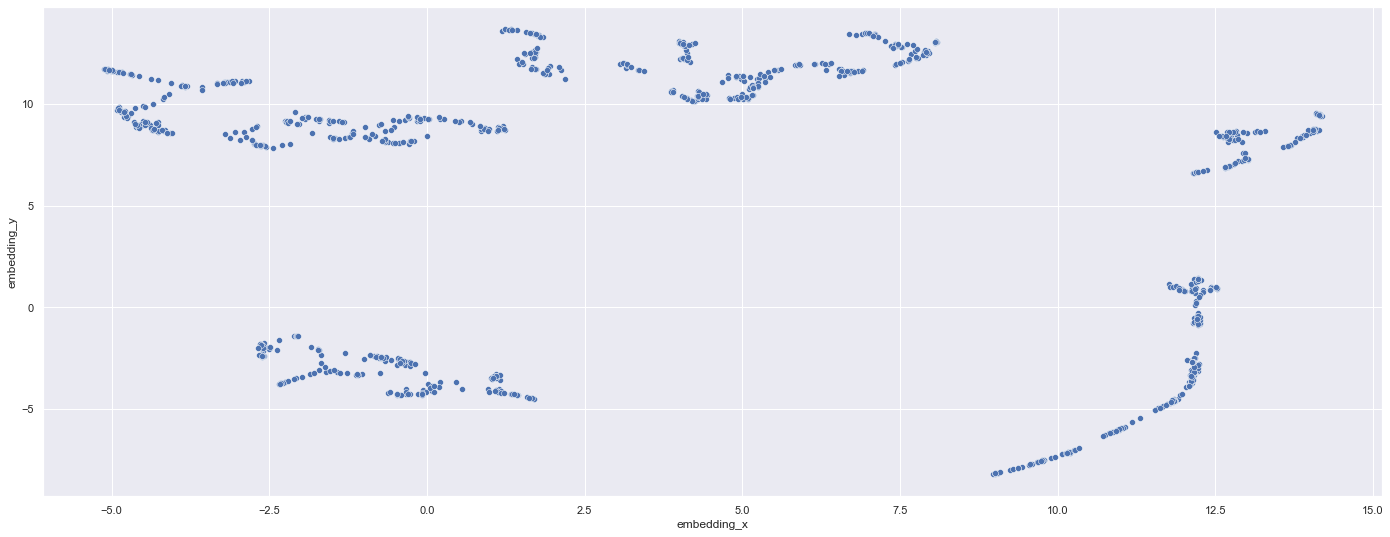

In [97]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )

embedding = reducer.fit_transform( df_leaf )
pickle.dump(reducer, open('../src/features/umap_reducer.pkl', 'wb'))
pickle.dump(reducer, fs.open('s3://df-insiders/artifacts/umap_reducer.pkl', 'wb'))

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

In [61]:
df_tree.shape

(995, 2)

# <font color='red'> 5.0. Data Preparation </font>

In [62]:
df5 = df_tree.copy()
df5.head()

,embedding_x,embedding_y
0,1.53,11.99
1,-0.33,-2.81
2,-2.74,8.05
3,0.21,-3.68
4,12.75,8.32


## 5.1. NORMALIZATION

## 5.2. RESCALLING

## 5.3. TRANSFORMATION

# <font color='red'> 6.0. Feature Selection </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [63]:
X = df5.copy()

In [64]:
clusters = range(2, 50)
#[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ]

In [65]:
X.shape

(995, 2)

# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

## 8.1. K-Means

In [66]:
# model definition
k = 5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [67]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

#WSS Values: 5546.332248871417
#SS Values: 0.6702106595039368

WSS Values: 5546.332248871417
SS Values: 0.6702106595039368


# <font color='red'> 9.0. Cluster Analysis </font>

In [68]:
df9 = df4_a.copy()
df9['cluster'] = labels
df9.head()

,customer_id,range_0_5,range_5_10,range_10_50,range_50_100,range_100,total_postal,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,devolution,p_total,avg_incoming,cluster
2,12348,2332,0,0,0,0,360.00,1437.24,283,70.75,5.08,0.00,1.20,359.31,0
9,12356,1450,42,81,0,0,324.00,2487.43,303,101.00,8.21,-0.00,0.28,829.14,1
11,12358,166,74,2,0,0,240.00,928.06,149,74.50,6.23,0.00,1.29,464.03,3
13,12360,1100,32,24,0,0,360.00,2302.06,148,49.33,15.55,-0.00,1.49,767.35,1
16,12363,402,6,0,0,0,0.00,552.00,133,66.50,4.15,0.00,0.85,276.00,2


In [69]:
X_l = X.copy()
X_l['cluster'] = labels
X_l.head()

,embedding_x,embedding_y,cluster
0,1.53,11.99,0
1,-0.33,-2.81,1
2,-2.74,8.05,3
3,0.21,-3.68,1
4,12.75,8.32,2


## 9.1. Visualization

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

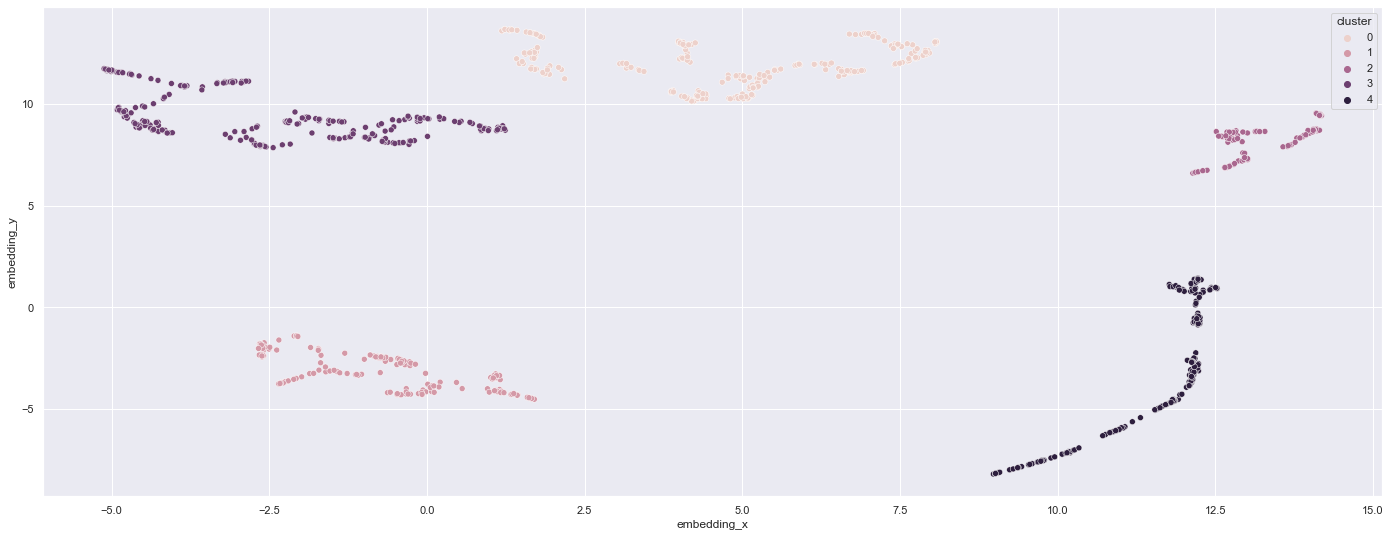

In [70]:
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=X_l, hue='cluster')

## 9.1. Cluster Profile

In [71]:
df9.columns

Index(['customer_id', 'range_0_5', 'range_5_10', 'range_10_50', 'range_50_100',
       'range_100', 'total_postal', 'total_gross_revenue_adj', 'date_interval',
       'buy_rate', 'customer_by_day', 'devolution', 'p_total', 'avg_incoming',
       'cluster'],
      dtype='object')

In [72]:
df_cluster = pd.DataFrame()
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'total_customers'})
df_cluster['perc_customer'] = 100*(df_cluster['total_customers'] / df_cluster['total_customers'].sum())

## Avg quantity
#df_avg_avg_qt = df9[['quantity', 'cluster']].groupby('cluster').mean().reset_index()
#df_cluster = pd.merge(df_cluster, df_avg_avg_qt, how='inner', on='cluster')

# Avg total postal
df_avg_total_postal = df9[['total_postal', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_total_postal, how='inner', on='cluster')

## Avg invoice
#df_avg_invoice_no = df9[['total_invoices', 'cluster']].groupby('cluster').mean().reset_index()
#df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg total_gross_revenue_adj
df_avg_gav_ajd = df9[['total_gross_revenue_adj', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg date_interval
df_avg_gav_ajd = df9[['date_interval', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg buy_rate
df_avg_gav_ajd = df9[['buy_rate', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg customer_by_day
df_avg_gav_ajd = df9[['customer_by_day', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')

# Avg p_total
df_avg_p_total = df9[['p_total', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_p_total, how='inner', on='cluster')

# Avg avg_incomingl
df_avg_p_total = df9[['avg_incoming', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_p_total, how='inner', on='cluster')

In [73]:
df_cluster.sort_values('avg_incoming', ascending=False)

,cluster,total_customers,perc_customer,total_postal,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,p_total,avg_incoming
1,1,177,17.79,54.21,3883.61,251.51,41.30,18.93,5.27,618.76
3,3,254,25.53,15.29,1192.19,114.60,34.35,16.29,4.49,376.39
0,0,257,25.83,6.80,964.83,255.92,71.41,3.91,3.30,262.52
2,2,101,10.15,6.98,509.01,166.48,63.94,7.12,2.27,204.26
4,4,206,20.70,2.24,287.79,141.52,64.34,4.20,1.42,131.73


### Cluster 01:  ( Candidate for Insiders ) - NOT UPDATED
    - Number of Customers: 20 (0,35% of customers )
    - Avg Invoice: 65,35
    - Avg Gross Revenue Adjusted: $94.772,63	
        
### Cluster 02: (New customers with low invoice)
    - Number of Customers: 3704 (65,09% of customers )
    - Avg Invoice: 1,61
    - Avg Gross Revenue Adjusted: $762,10
        
### Cluster 03: (Old customers with low revenue)
    - Number of Customers: 1967 (34,56% of customers )
    - Avg Invoice: 8,08
    - Avg Gross Revenue Adjusted: $2.580,80

In [74]:
df9[df9['cluster'] == 1].sort_values('p_total', ascending=False).head(50)

,customer_id,range_0_5,range_5_10,range_10_50,range_50_100,range_100,total_postal,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,devolution,p_total,avg_incoming,cluster
694,13263,4479,256,38,0,0,0.00,7439.07,324,9.53,22.96,-10.22,51.44,218.80,1
1139,13880,1793,42,7,0,0,0.00,3219.77,346,26.62,9.31,0.00,31.92,247.67,1
3299,16814,2366,367,30,0,0,0.00,6500.60,355,16.14,18.31,-1.40,22.78,295.48,1
167,12557,4384,0,0,0,0,0.00,11990.96,355,71.00,33.78,0.00,18.34,2398.19,1
4043,17857,14822,0,0,0,0,0.00,26763.34,362,14.48,73.93,-1461.80,17.87,1070.53,1
3708,17396,1748,144,112,0,0,0.00,7330.80,332,41.50,22.08,-18.00,17.40,916.35,1
3036,16458,2148,6,0,0,0,0.00,3482.74,358,19.89,9.73,0.00,16.96,193.49,1
2751,16081,1402,51,24,0,0,0.00,2806.90,310,62.00,9.05,-0.00,16.81,561.38,1
4157,18008,1562,11,8,0,0,0.00,2116.19,248,27.56,8.53,0.00,15.18,235.13,1
312,12726,3084,48,0,0,0,198.00,2411.10,329,47.00,7.33,0.00,14.83,344.44,1


In [75]:
df9[df9['cluster'] == 3].sort_values('p_total', ascending=False).head(50)

,customer_id,range_0_5,range_5_10,range_10_50,range_50_100,range_100,total_postal,total_gross_revenue_adj,date_interval,buy_rate,customer_by_day,devolution,p_total,avg_incoming,cluster
1432,14285,402,108,31,0,0,0.00,1910.01,155,38.75,12.32,-0.00,322.73,477.50,3
3201,16692,0,151,0,0,0,150.00,1126.00,33,16.50,34.12,0.00,131.47,563.00,3
4000,17788,101,109,0,0,0,4.95,1112.95,56,28.00,19.87,0.00,93.72,556.48,3
2442,15653,1200,0,0,0,0,0.00,877.44,23,11.50,38.15,0.00,17.28,438.72,3
774,13368,301,23,2,1,0,0.00,623.40,81,40.50,7.70,0.00,16.61,311.70,3
4239,18122,1179,40,3,1,0,0.00,1826.21,142,23.67,12.86,-6.17,14.27,304.37,3
3042,16466,729,47,13,0,0,0.00,1603.46,259,37.00,6.19,-0.00,13.36,229.07,3
1743,14704,974,66,32,0,0,0.00,1516.91,161,23.00,9.42,-12.24,12.66,216.70,3
3499,17092,1126,3,2,0,0,0.00,1777.78,227,56.75,7.83,-0.00,12.18,444.45,3
1526,14418,1654,38,18,1,0,0.00,1937.25,105,35.00,18.45,-0.00,11.88,645.75,3


In [76]:
df9.dtypes

customer_id                  int64
range_0_5                    int64
range_5_10                   int64
range_10_50                  int64
range_50_100                 int64
range_100                    int64
total_postal               float64
total_gross_revenue_adj    float64
date_interval                int64
buy_rate                   float64
customer_by_day            float64
devolution                 float64
p_total                    float64
avg_incoming               float64
cluster                      int32
dtype: object

# <font color='red'> 10.0. Deploy To Production </font>

In [77]:
import sqlite3
from sqlalchemy import create_engine

In [78]:
conn = sqlite3.connect('insiders_db.sqlite')

# drop table
query_drop_insiders = """
    DROP TABLE insiders
"""
conn.execute( query_drop_insiders )

# create table
query_create_insiders = """
    CREATE TABLE insiders ( 
        customer_id             INTEGER,
        range_0_5               INTEGER,
        range_5_10              INTEGER,
        range_10_50             INTEGER,
        range_50_100            INTEGER,
        range_100               INTEGER,
        total_postal            REAL,
        total_gross_revenue_adj REAL,
        date_interval           INTEGER,
        buy_rate                REAL,
        customer_by_day         REAL,
        devolution              REAL,
        p_total                 REAL,
        avg_incoming            REAL,
        cluster                 INTEGER
    )
"""
conn.execute( query_create_insiders )
conn.commit()
conn.close()

In [79]:
# insert data
conn = create_engine('sqlite:///insiders_db.sqlite')
df9.to_sql('insiders', con=conn, if_exists='append', index=False) # index=False - ignorar conflito de índices (quando já existe um ocupado e a nova tabela possui o mesmo indice)

In [82]:
## get query
#query_collect = """
#    SELECT * from insiders
#"""
#
#df = pd.read_sql_query( query_collect, conn )
#df.head()